# Text Indexing

*Information Retrieval* is about *selecting* the documents from a - possibly large - collection that match the *query*, and *ranking* the result set according to relevance. One obvious use-case are internet search engines, but efficient and precise search is needed in many other applications.

## Selection

The first part of retrieval is finding the documents that are match the query, ignoring their relative relevance for now.

One obvious way to do this what we have already done for the secondary indexing case with the global city database. We created an *inverted index* or *inverted file*: a dictionary that records the set of documents (cities) that match a search term.

This is the similar to the index at the back of a book, which maps index terms to pages:

<img src="figures/book-index.png" alt="Index" width="400"/>

## Tokenization
The first step is to turn a document into words, or _tokens_. A first attempt probably uses `string.split()`, but we should be aware that not all languages use whitespace (such as spaces) to separate words (Thai, for instance).

Also, we want to remove punctuation from our tokens, and it might be convenient to turn all words to lower-case.

In [77]:
documents = {
    1: "Ein Film über Sterne mit Harrison Ford.",
    2: "Ein Film über Sterne von Antoine de Saint-Exupéry.",
    3: "In diesem Film gewinnt James Bond gegen Dr. No.",
}

def extract_terms(document):
    import string, re
    for word in document.split():
        # 1) skip two-letter words
        # 2) strip punctuation at word boundaries
        # 3) transform to lower-case
        if len(word) > 2:
            yield word.strip(string.punctuation).lower()
    # Alternative: use regular expressions
    #yield from re.findall("\w+", document)

for word in extract_terms(documents[1]): print(word)

ein
film
über
sterne
mit
harrison
ford


What is an index? A set of page numbers (in our case: document identifiers) that match a word. We build a dictionary mapping from each word to the set of documents in which it occurs:

In [78]:
def build_text_index(tuples):
    """Builds and returns a full-text index over all (id, document) tuples given."""
    from tqdm.auto import tqdm
    index = dict()
    for id, document in tqdm(tuples):
        for term in extract_terms(document):
            index.setdefault(term, set()).add(id)
    return index

index = build_text_index(documents.items())
index

  0%|          | 0/3 [00:00<?, ?it/s]

{'ein': {1, 2},
 'film': {1, 2, 3},
 'über': {1, 2},
 'sterne': {1, 2},
 'mit': {1},
 'harrison': {1},
 'ford': {1},
 'von': {2},
 'antoine': {2},
 'saint-exupéry': {2},
 'diesem': {3},
 'gewinnt': {3},
 'james': {3},
 'bond': {3},
 'gegen': {3},
 'dr': {3},
 'no': {3}}

### Querying

We can query directly as follows:

In [79]:
def query_index(index, query):
    return index.get(query, set())

query_index(index, "sterne")

{1, 2}

If our query is more than a single word, the above fails. Conveniently, we use the same term extractor on the query as we used for indexing and query the index for each word (_token_) separately. We then need to decide how the results for each token should be combined to form the final result set.

Shall we include only documents contained in each per-token results (the _intersection_ of all results)?

Or rather combine all result sets, producing their _union_?

In [80]:
def query_index(index, query):
    result_set = None
    for term in extract_terms(query):
        results = index.get(term, set())
        result_set = results if result_set is None else result_set.intersection(results)
    return result_set

query_index(index, "ford sterne")

{1}

## Bigger Dataset: 1970s Movies

Let's move up to a slightly bigger dataset: the German wikipedia movie articles of 1985, the 1970s or 1980s.
  * Movies of 1985 (`data/movies_1985.csv.zip`)
  * Movies of the 1970ies (`data/movies_197x.csv.zip`)
  * Movies of the 1980ies (`data/movies_198x.csv.zip`)
  * Movies of the 1990ies (`data/movies_199x.csv.zip`)

The CSVs have two columns: the wikipedia url as identifier, and the full article as text.
More datasets may be found at https://if.ksr.ch/talit/indexing.

The following function will yield a stream of `(identifier, text)` tuples ready for indexing:

In [81]:
def read_movie_csv(filename):
    """Reads a two-column CSV of Wikipedia articles and yields each (id, text)pair contained therein."""
    import csv
    with open(filename, 'r', encoding='UTF-8') as csvfile:
        reader = csv.reader(csvfile)
        for url, text in reader:
            yield url, text

We can index the movie-datasets with our existing index building code:

In [82]:
dataset = 'data/movies_198x.csv'
movie_index = build_text_index(read_movie_csv(dataset))

0it [00:00, ?it/s]

A quick query reveals that our index is able to produce meaningful results:

In [83]:
query_index(movie_index, "delorean")

{'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_(Film)',
 'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_II'}

## Stop Wording

Looking at our index more closely, we find that many words provide little value. For instance, the word `der` appears in 4009 of the 4014 documents:

In [84]:
len(query_index(movie_index, "der"))

4009

Why even store that information and spend index for something that brings no value? In practice, we'd want to apply a technique called _Stop Wording_ to our indexing: Words known to appear frequently should be dropped from indexing and also from the query.

We could download a list of stopwords from the internet - but don't we have that information already in our pipeline? Each word stores the set of documents where it appears. The length of that set divided by the total number of documents gives us the _relative document frequency_.

Let's list all our index tokens along with their frequency:

In [100]:
n = sum(1 for _ in read_movie_csv(dataset))
freqs = [(word, len(docs) / n) for word, docs in movie_index.items()]
import operator
freqs.sort(reverse=True, key=operator.itemgetter(1))
freqs[:10]

[('der', 0.9987543597409069),
 ('ist', 0.9980069755854509),
 ('und', 0.9955156950672646),
 ('die', 0.9915296462381664),
 ('weblinks', 0.989785749875436),
 ('von', 0.9778276033881415),
 ('ein', 0.9770802192326856),
 ('dem', 0.9750871948181365),
 ('den', 0.9673642252117588),
 ('internet', 0.9646238166417539)]

Clearly, we don't want any of these. Let's produce a set of stopwords that includes all words that appear in more than one third of the documents:

In [86]:
cutoff = 1/3
stopwords = {word for word, freq in freqs if freq > cutoff}
len(stopwords)

96

We can now adapt our term extractor to skip any words in our stopword list:

In [87]:
def extract_terms(document, stop_words=stopwords):
    import string, re
    for word in document.split():
        # 1) skip two-letter words
        # 2) strip punctuation at word boundaries
        # 3) transform to lower-case
        if len(word) > 2:
            word = word.strip(string.punctuation).lower()
            if not word in stop_words:
                yield word
    # Alternative: use regular expressions
    #yield from re.findall("\w+", document)


Re-building the index over the toy dataset shows that frequent words such as `film` no longer appear in the index:

In [88]:
index = build_text_index(documents.items())
index

  0%|          | 0/3 [00:00<?, ?it/s]

{'sterne': {1, 2},
 'harrison': {1},
 'ford': {1},
 'antoine': {2},
 'saint-exupéry': {2},
 'diesem': {3},
 'gewinnt': {3},
 'james': {3},
 'bond': {3},
 'gegen': {3},
 'dr': {3},
 'no': {3}}

### Term Extraction: Filtering & Expansion

A more sophisticated term extractor would likely perform additional filtering and expansions:
  * transform words to their stems (`donuts` --> `donut`)
  * add synonyms (`donut` --> `pastry`)
  * expand acronmys (`HTML` --> `hypertext markup language`)
  * fix common typos (`abreviation` --> `abbreviation`)

## Ranking

We really care about which document is the best match for a query. We also want to avoid dropping a good search result simply because one minor search term does not appear in it. Let's rephrase search to include all documents that contain any of the search terms (instead of all of them):

In [93]:
def query_index_union(index, query):
    result_set = None
    for term in extract_terms(query):
        results = index.get(term, set())
        result_set = results if result_set is None else result_set.union(results)
    return result_set


### Querying with Union

While a specific query such as `delorean` works fine, query terms that appear frequently blow up the search results:

In [95]:
len(query_index_union(movie_index, "michael fox delorean"))

522

Clearly, some terms are more interesting than others. But which terms are interesting? Clearly, a term that appears in all or most documents is quite uninteresting. We can use our stop-wording approach again to find out the document frequency for our search terms.

First, let's turn the frequency table into a dictionary that supports quick lookup:

In [111]:
word_frequencies = {word: freq for word, freq in freqs}

table = [['Term', 'Relative Document Frequency']]
for token in extract_terms("michael fox delorean"):
    table.append([token, word_frequencies[token]])

%pip install tabulate
from tabulate import tabulate
tabulate(table, headers="firstrow", floatfmt=".2%", tablefmt='html')

Note: you may need to restart the kernel to use updated packages.


Term,Relative Document Frequency
michael,11.98%
fox,1.77%
delorean,0.05%


### Visualize term frequencies

If we are to use the term frequency to compute an overall rank of the search results, it would be nice if we could somehow add up the contributions of each term. For this, it is important to know the shape of the term frequencies.

Let's plot them:

['der', 'telefonanruf', 'kovács', 'konklave', 'bardili', 'teetjen', 'sehen.das', 'zement', 'maues', '13,8', 'emotionen“']


/var/folders/rs/4ym7352x37df592tnnlbw2mm0000gn/T/ipykernel_68883/527513099.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None] + labels[0:-1:label_multiple], rotation=90)


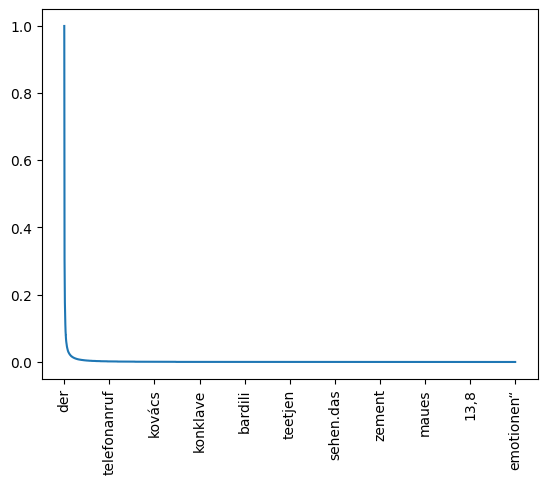

In [112]:
#!pip install matplotlib

def plot_terms(terms):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math

    labels = [x for x, y in terms.items()]
    values = [y for x, y in terms.items()]
    fig, ax = plt.subplots() 
    #ax.set_yscale('log')
    label_count = 10
    label_multiple = len(terms) // label_count
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(label_multiple, 0))
    ax.set_xticklabels([None] + labels[0:-1:label_multiple], rotation=90)
    print(labels[0:-1:label_multiple])
    ax.plot(values)

plot_terms(word_frequencies)

Hm, this surely looks like a [power law distribution](https://en.wikipedia.org/wiki/Power_law). Indeed, [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) states that the most common word appears roughly twice as often as the next common one.

Applying a log to the (inverted) frequency would probably help with making the value useful for ranking:

Michael: 2.1, Fox: 4, delorean: 7.6
['der', 'telefonanruf', 'kovács', 'konklave', 'bardili', 'teetjen', 'sehen.das', 'zement', 'maues', '13,8', 'emotionen“']


/var/folders/rs/4ym7352x37df592tnnlbw2mm0000gn/T/ipykernel_68883/527513099.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None] + labels[0:-1:label_multiple], rotation=90)


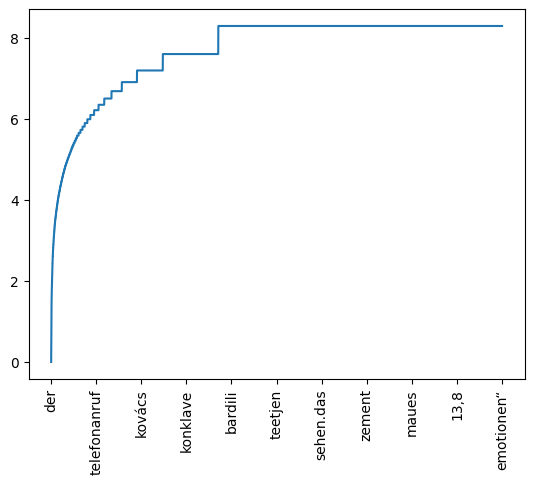

In [116]:
import math
log_terms = {term: math.log(1/weight) for term, weight in word_frequencies.items()}
print(f"Michael: {log_terms['michael']:.2g}, Fox: {log_terms['fox']:.2g}, delorean: {log_terms['delorean']:.2g}")

plot_terms(log_terms)

### Ranking: Putting things together
Let's rank the search results by summing up the IDF values for each search term:

In [123]:
def query_index_weighted(index, query, k=10):
    """Returns the top k search results matching query."""
    result_set = dict()
    for term in extract_terms(query):
        idf = log_terms[term]
        results = index.get(term, set())
        for result in results:
            result_set[result] = result_set.get(result, 0) + idf
    return dict(sorted(result_set.items(), reverse=True, key=lambda item: item[1])[:k])

Ah, now _Back to the Future_ at last appears in the top search results:

In [124]:
query_index_weighted(movie_index, "michael fox delorean")

{'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_(Film)': 13.760936260361827,
 'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_II': 13.760936260361827,
 'https://de.wikipedia.org/wiki/Ein_Fisch_namens_Wanda': 6.15653991156549,
 'https://de.wikipedia.org/wiki/James_Bond_007_%E2%80%93_Im_Angesicht_des_Todes': 6.15653991156549,
 'https://de.wikipedia.org/wiki/Alarmstufe_1_(1985)': 6.15653991156549,
 'https://de.wikipedia.org/wiki/Die_Zeitfalle': 6.15653991156549,
 'https://de.wikipedia.org/wiki/James_Bond_007_%E2%80%93_Lizenz_zum_T%C3%B6ten': 6.15653991156549,
 'https://de.wikipedia.org/wiki/Stirb_langsam': 6.15653991156549,
 'https://de.wikipedia.org/wiki/High_School_U.S.A.': 6.15653991156549,
 'https://de.wikipedia.org/wiki/James_Bond_007_%E2%80%93_In_t%C3%B6dlicher_Mission': 6.15653991156549}